# Random Number Generation Experiments


![RNG diagram](../rng.png)


## Introduction

This notebook sets up experiments comparing different methods for training language models to generate random numbers from specified distributions.

We will focus on sampling numbers from various distributions.

The models we will compare are:

- GFN-fine-tuned LM: Fine-tuned via generative flow networks
- Likelihood-trained LM: Supervised-fine-tuned LM
- RL-tuned LM: Fine-tuned via reinforcement learning (PPO)


Several axes of experimentation:

- vary the distribution
  - discrete: uniform, Poisson, Binomial, Geometric, etc
  - continuous: uniform, Gaussian, exponential, etc
- vary the hyperparameters of the distribution (in the context)
  - Uniform: between 0 and `n_max`
  - Poisson: `lambda` between `λ_min` and `λ_max`
  - etc
- vary the prompt
  - 'Randomly generate (uniformly) one single random integer between 0 and {num_test}, and then stop: '
  - 'Randomly generate (uniformly) one single random integer in the interval [0, {num_test}]: '
  - 'Here is one single random integer sampled uniformly between 0 and {num_test}: '
  - "The following is a random integer drawn uniformly between 0 and {num_test}: "
  - etc
- vary the model
  - GFN-LM
  - PPO
  - MLE (SFT)


## General imports


In [ ]:
import os
import sys
import hydra
from hydra.experimental import initialize, compose

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model, PeftModel

[2023-09-28 08:07:53,774] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [ ]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import shutil

import seaborn as sns
from IPython.display import display, Markdown

# # Remove the matplotlib cache
# shutil.rmtree(matplotlib.get_cachedir())

fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# print the names of all fonts
font_names = [matplotlib.font_manager.get_font(x).family_name for x in fonts]
print(font_names)

fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(fonts)
print("Times New Roman" in fonts)

plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rc("font", family="Times New Roman")

print(matplotlib.get_configdir())
print(matplotlib.get_cachedir())

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
!nvidia-smi

Thu Sep 28 08:07:56 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:0F:00.0 Off |                    0 |
| N/A   24C    P0              60W / 400W |      7MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
import gc

with torch.no_grad():
    gc.collect()
    torch.cuda.empty_cache()

# Load the pretrained model


In [ ]:
# Initialize Hydra
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="multiobjective-lm/rng/configs")
cfg = compose(config_name="config")

bsz = cfg.hparams.bsz
grad_acc = cfg.hparams.grad_acc
lr = cfg.hparams.lr
warmup_steps = cfg.hparams.warmup_steps
epochs = cfg.hparams.epochs
max_len = cfg.hparams.max_len
min_len = cfg.hparams.min_len
eval_interval = cfg.hparams.eval_interval
log_interval = cfg.hparams.log_interval
model_to_use = cfg.hparams.model_to_use
seed = cfg.hparams.seed
save_dir = cfg.hparams.save_dir
sft_epochs = cfg.hparams.SFT.epochs

In [10]:
# Set the seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
if model_to_use == "gpt-j":
    tokenizer = AutoTokenizer.from_pretrained("nlpcloud/instruct-gpt-j-fp16")
    model = AutoModelForCausalLM.from_pretrained(
        "nlpcloud/instruct-gpt-j-fp16", torch_dtype=torch.bfloat16
    )
elif model_to_use == "gpt2":
    tokenizer = AutoTokenizer.from_pretrained("gpt2")
    model = AutoModelForCausalLM.from_pretrained("gpt2")

model.to("cuda")

GPTJForCausalLM(
  (transformer): GPTJModel(
    (wte): Embedding(50400, 4096)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-27): 28 x GPTJBlock(
        (ln_1): LayerNorm((4096,), eps=1e-05, elementwise_affine=True)
        (attn): GPTJAttention(
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (out_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): GPTJMLP(
          (fc_in): Linear(in_features=4096, out_features=16384, bias=True)
          (fc_out): Linear(in_features=16384, out_features=4096, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f)

# Training


## LoRA, Optimizer, and Scheduler


In [12]:
lora_config = LoraConfig(
    r=cfg.lora.r,
    lora_alpha=cfg.lora.lora_alpha,
    target_modules=["k_proj", "v_proj"] if model_to_use == "gpt-j" else ["c_attn"],
    lora_dropout=cfg.lora.lora_dropout,
    bias=cfg.lora.bias,
)
inference_model = get_peft_model(model, lora_config)

opt = torch.optim.AdamW(
    [{"params": inference_model.parameters(), "lr": lr}],
    betas=(cfg.adamw.b1, cfg.adamw.b2),
)

## Dataloaders


In [13]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

In [15]:
from rng.rng_dataset import get_dataloader_from_dataframe

df_train = pd.read_csv(cfg.file_name.train)

train_loader = get_dataloader_from_dataframe(
    df_train, tokenizer, bsz=bsz, shuffle=True, method="SFT"
)

Tokenizing dataset...: 4096it [00:01, 2764.58it/s]


In [16]:
total_steps = epochs * len(train_loader)


# learning rate schedule
def get_lr_mult_at_step(step):
    if step <= warmup_steps:
        return min(step / warmup_steps, 1.0)
    return max((total_steps - step) / (total_steps - warmup_steps), 0)


sched = torch.optim.lr_scheduler.LambdaLR(opt, get_lr_mult_at_step)

In [17]:
df_train.head()

,Prompt,Value,Distribution and Parameters,Distribution,Parameters,Data Type,Distribution and Parameters Index
0,The following is a random integer drawn from a...,80,"{""distribution"": ""uniform discrete"", ""data_typ...",uniform discrete,"{""a"": 0, ""b"": 100}",int,0
1,The following is a random integer drawn from a...,69,"{""distribution"": ""uniform discrete"", ""data_typ...",uniform discrete,"{""a"": 0, ""b"": 100}",int,0
2,The following is a random integer drawn from a...,67,"{""distribution"": ""uniform discrete"", ""data_typ...",uniform discrete,"{""a"": 0, ""b"": 100}",int,0
3,Randomly generate one single random integer fr...,99,"{""distribution"": ""uniform discrete"", ""data_typ...",uniform discrete,"{""a"": 0, ""b"": 100}",int,0
4,Here is one single random integer sampled from...,53,"{""distribution"": ""uniform discrete"", ""data_typ...",uniform discrete,"{""a"": 0, ""b"": 100}",int,0


## Training loop


In [ ]:
inference_model.train()
for epoch in range(sft_epochs):
    for i, batch in tqdm(enumerate(train_loader), desc=f"Epoch {epoch}"):
        opt.zero_grad()
        input_ids, target_ids = batch
        outputs = inference_model(input_ids, labels=target_ids)
        loss = outputs.loss
        loss.backward()
        opt.step()
        sched.step()
        if i % log_interval == 0:
            print(f"Epoch: {epoch}, Batch: {i}, Loss: {loss.item()}")

### Save the model


In [31]:
ckpt_name = f"rng-SFT_{model_to_use}_bsz_{bsz}_grad_acc_{grad_acc}_lr_{lr}_warmup_steps_{warmup_steps}_epochs_{sft_epochs}_max_len_{max_len}_min_len_{min_len}_eval_interval_{eval_interval}_log_interval_{log_interval}_training_samples_{len(train_loader)}_seed_{seed}"
inference_model.save_pretrained(f"{save_dir}/{ckpt_name}")

# Evaluation


In [ ]:
# ckpt_name = "rng-SFT_gpt-j_bsz_8_grad_acc_1_lr_5e-05_warmup_steps_100_epochs_10_max_len_512_min_len_1_eval_interval_100_log_interval_10_seed_42"
# model_path = f"{save_dir}/{ckpt_name}"
# inference_model = PeftModel.from_pretrained(model, model_path)

In [20]:
inference_model.eval()
with torch.inference_mode():
    prompt_test = "Randomly generate (uniformly) one single random integer between 0 and 520, and then stop: "
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

    prompt_test = (
        "Here is one single random integer sampled uniformly between 0 and 520: "
    )
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['51', '<|endoftext|>']
['0', '<|endoftext|>']


In [21]:
from rng.rng_utils import get_distribution

n_max = 100
intro_prompt = f"The following is a random integer drawn uniformly between 0 and "
prompt = f"{intro_prompt}{n_max-1}: "

In [22]:
from rng.rng_plot import plot_distribution

n_samples = 1000 * 512

In [23]:
inference_model.base_model.enable_adapter_layers()

dist_inference, number_of_NaNs_inference = get_distribution(
    inference_model, tokenizer, prompt, num_samples=n_samples
)

100%|██████████| 1000/1000 [15:18<00:00,  1.09it/s]


## SFT-finetuned Model: Distribution of generated numbers

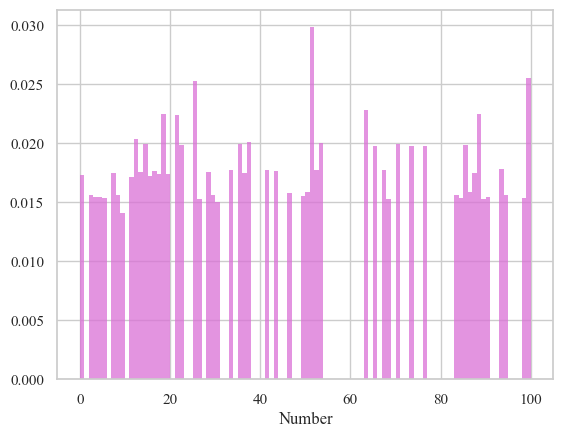

In [27]:
plot_distribution(
    dist_inference,
    n_max=n_max,
    model_name="SFT-finetuned Model",
    color="orchid",
    number_of_NaNs=number_of_NaNs_inference,
    xlims=(-5, n_max + 5),
)

In [32]:
if not os.path.exists("plots"):
    os.makedirs("plots")

df_inference = pd.DataFrame(dist_inference, columns=["Generated Numbers"])
df_inference.to_csv(f"plots/SFT-dist_inference_{ckpt_name}.csv", index=False)